# 제품 이상여부 판별 프로젝트


In [14]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 데이터 불러오기


### 필수 라이브러리


In [2]:
pip install seaborn

In [15]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

### 데이터 읽어오기


In [16]:
ROOT_DIR = "/content/drive/MyDrive/LG_AIMERS/data"
# ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

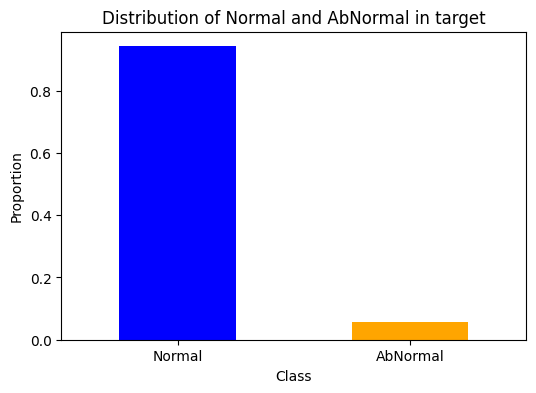

In [17]:

# Target distribution visualization
target_counts = train_data['target'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
target_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Normal and AbNormal in target')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

## 데이터 이해

세그먼트별 불량률:
Dam: 5.8016%
Fill2: 5.8016%
AutoClave: 5.8016%


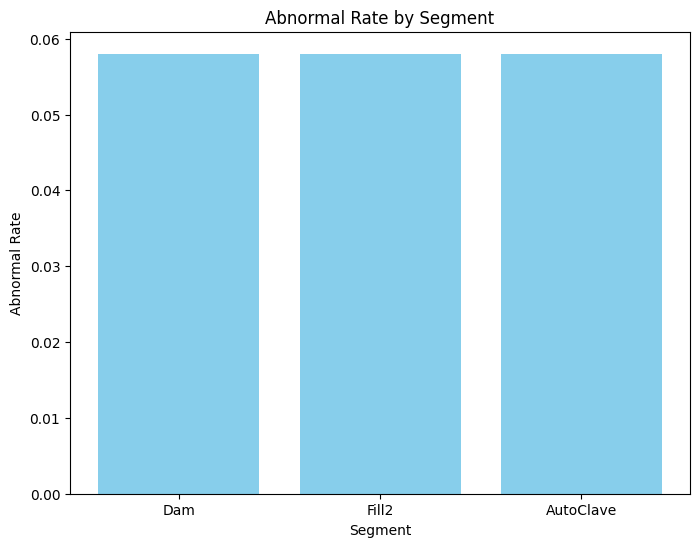

In [6]:
# 세그먼트별 불량률을 계산하기 위해 불량 여부를 숫자로 변환
train_data['is_abnormal'] = train_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)

# 세그먼트별로 변수 그룹화 (예: Dam, Fill2, AutoClave 등)
segments = {
    'Dam': [col for col in train_data.columns if '_Dam' in col],
    'Fill2': [col for col in train_data.columns if '_Fill2' in col],
    'AutoClave': [col for col in train_data.columns if '_AutoClave' in col]
}

# 각 세그먼트별 불량률 계산
segment_abnormal_rates = {}
for segment_name, segment_columns in segments.items():
    segment_data = train_data[segment_columns + ['is_abnormal']]
    abnormal_rate = segment_data['is_abnormal'].mean()
    segment_abnormal_rates[segment_name] = abnormal_rate

# 결과 출력
print("세그먼트별 불량률:")
for segment, rate in segment_abnormal_rates.items():
    print(f"{segment}: {rate:.4%}")

# 불량률 시각화
plt.figure(figsize=(8, 6))
plt.bar(segment_abnormal_rates.keys(), segment_abnormal_rates.values(), color='skyblue')
plt.title('Abnormal Rate by Segment')
plt.xlabel('Segment')
plt.ylabel('Abnormal Rate')
plt.show()


In [11]:
# Let's first get some basic statistics and understand the distribution of the target variable
data_description = train_data.describe(include='all')
target_distribution = train_data['target'].value_counts(normalize=True)

# Let's check for any specific insights regarding the target distribution and overall structure
data_description, target_distribution

(       Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
 count         40506             40506             40506            40506   
 unique            1                 1                 2                7   
 top         IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
 freq          40506             40506             25030            33820   
 mean            NaN               NaN               NaN              NaN   
 std             NaN               NaN               NaN              NaN   
 min             NaN               NaN               NaN              NaN   
 25%             NaN               NaN               NaN              NaN   
 50%             NaN               NaN               NaN              NaN   
 75%             NaN               NaN               NaN              NaN   
 max             NaN               NaN               NaN              NaN   
 
        Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
 count    

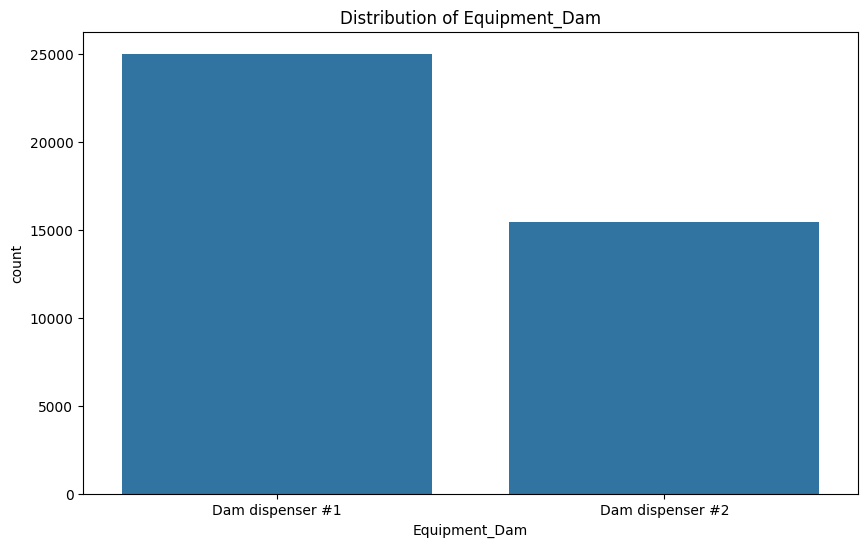

<Figure size 1000x600 with 0 Axes>

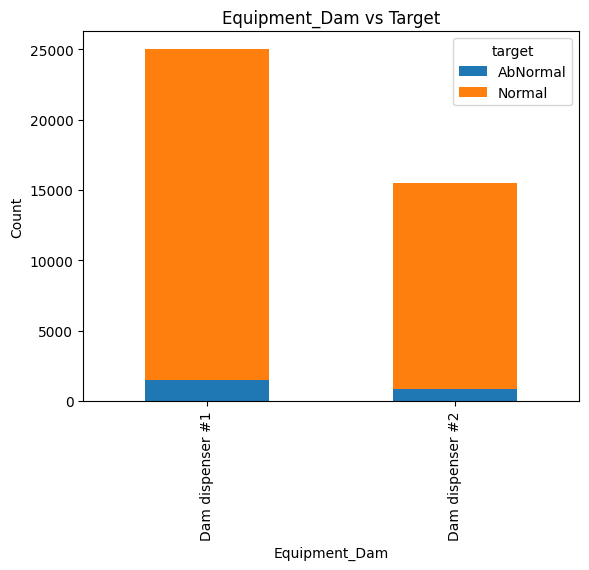

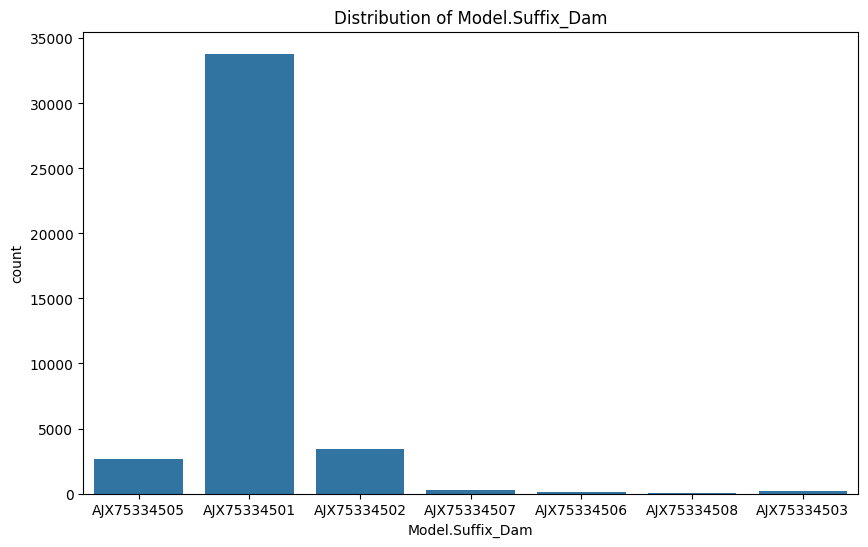

<Figure size 1000x600 with 0 Axes>

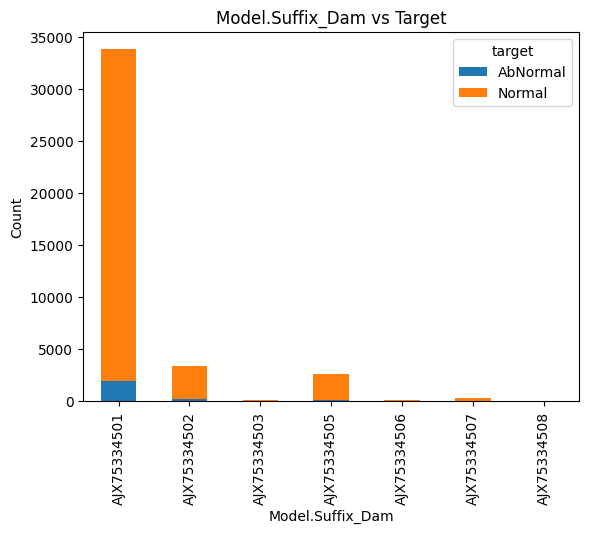

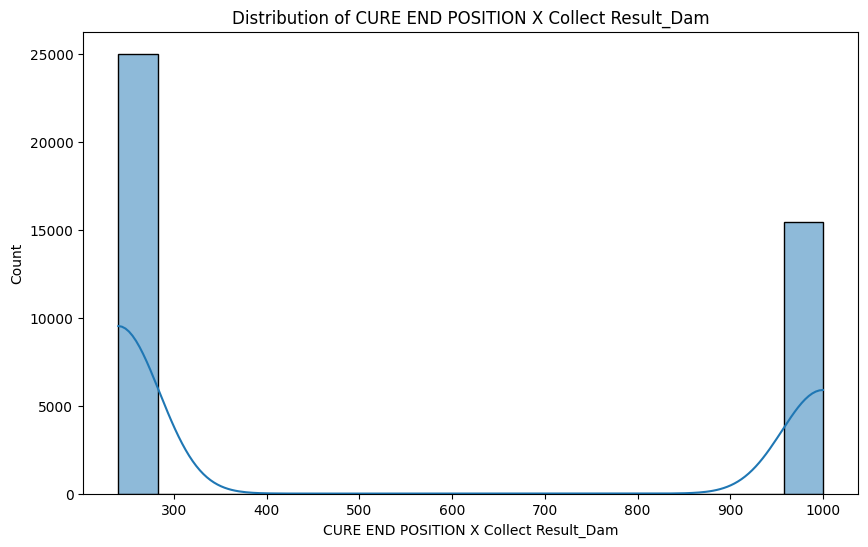

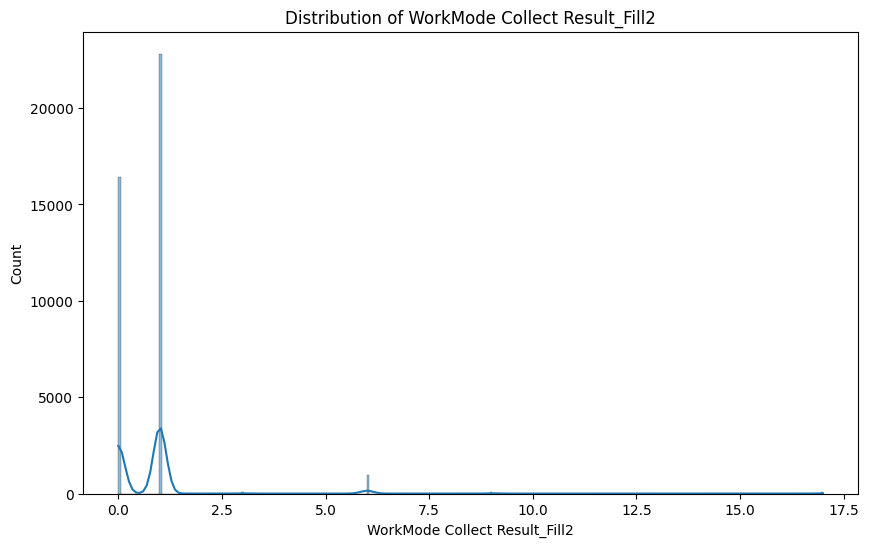

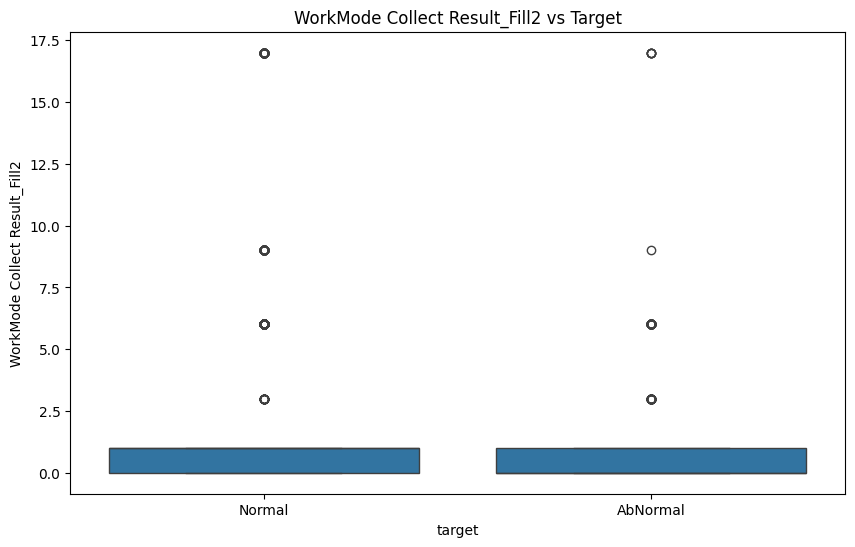

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Checking the distribution of 'Equipment_Dam' and its relation to 'target'
equipment_dam_distribution = train_data['Equipment_Dam'].value_counts()
equipment_dam_vs_target = pd.crosstab(train_data['Equipment_Dam'], train_data['target'])

# Plotting the distribution of 'Equipment_Dam'
plt.figure(figsize=(10, 6))
sns.countplot(x='Equipment_Dam', data=train_data)
plt.title('Distribution of Equipment_Dam')
plt.show()

# Plotting the relation between 'Equipment_Dam' and 'target'
plt.figure(figsize=(10, 6))
equipment_dam_vs_target.plot(kind='bar', stacked=True)
plt.title('Equipment_Dam vs Target')
plt.ylabel('Count')
plt.show()

# Analyzing the 'Model.Suffix_Dam' and its relation to 'target'
model_suffix_vs_target = pd.crosstab(train_data['Model.Suffix_Dam'], train_data['target'])

# Plotting the distribution of 'Model.Suffix_Dam'
plt.figure(figsize=(10, 6))
sns.countplot(x='Model.Suffix_Dam', data=train_data)
plt.title('Distribution of Model.Suffix_Dam')
plt.show()

# Plotting the relation between 'Model.Suffix_Dam' and 'target'
plt.figure(figsize=(10, 6))
model_suffix_vs_target.plot(kind='bar', stacked=True)
plt.title('Model.Suffix_Dam vs Target')
plt.ylabel('Count')
plt.show()

# Analyzing the 'CURE END POSITION X Collect Result_Dam' distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['CURE END POSITION X Collect Result_Dam'].dropna(), kde=True)
plt.title('Distribution of CURE END POSITION X Collect Result_Dam')
plt.show()

# Analyzing 'WorkMode Collect Result_Fill2' and its relation to 'target'
plt.figure(figsize=(10, 6))
sns.histplot(train_data['WorkMode Collect Result_Fill2'].dropna(), kde=True)
plt.title('Distribution of WorkMode Collect Result_Fill2')
plt.show()

# Plotting the relation between 'WorkMode Collect Result_Fill2' and 'target'
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='WorkMode Collect Result_Fill2', data=train_data)
plt.title('WorkMode Collect Result_Fill2 vs Target')
plt.show()


특정 장비(Dam dispenser #1)와 모델(AJX75334501)에서 불량이 상대적으로 더 많이 발생

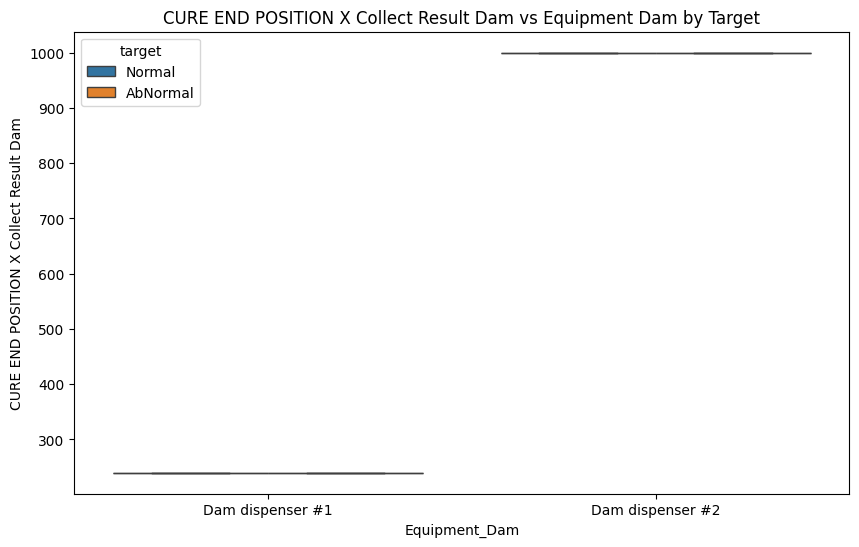

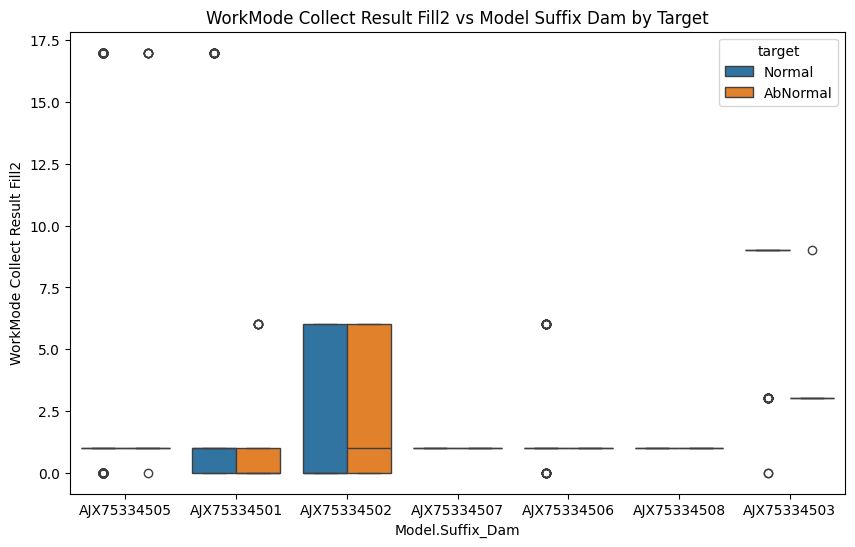

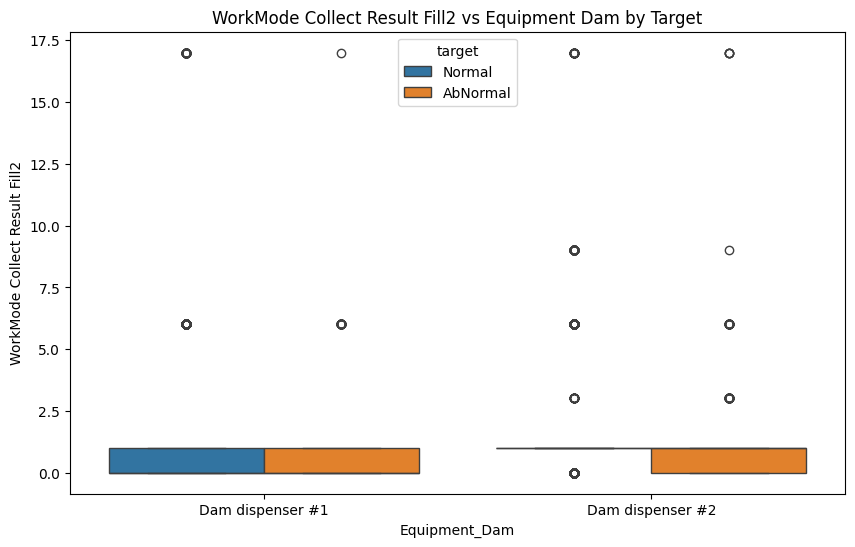

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Equipment_Dam과 Model.Suffix_Dam에서 불량이 많이 발생하는 구체적인 원인을 파악하기 위해,
# 두 변수와 다른 공정 관련 변수를 조합하여 추가 분석을 진행합니다.

# 1. Equipment_Dam과 다른 공정 변수(예: CURE END POSITION X Collect Result_Dam) 간의 관계 분석
# 특정 장비에서 불량이 발생할 때, 특정 위치에서의 문제인지 확인합니다.

plt.figure(figsize=(10, 6))
sns.boxplot(x='Equipment_Dam', y='CURE END POSITION X Collect Result_Dam', hue='target', data=train_data)
plt.title('CURE END POSITION X Collect Result Dam vs Equipment Dam by Target')
plt.ylabel('CURE END POSITION X Collect Result Dam')
plt.show()

# 2. Model.Suffix_Dam과 WorkMode Collect Result_Fill2 간의 관계 분석
# 특정 모델에서 특정 작업 모드가 불량 발생에 영향을 미치는지 확인합니다.

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model.Suffix_Dam', y='WorkMode Collect Result_Fill2', hue='target', data=train_data)
plt.title('WorkMode Collect Result Fill2 vs Model Suffix Dam by Target')
plt.ylabel('WorkMode Collect Result Fill2')
plt.show()

# 3. Equipment_Dam과 WorkMode Collect Result Fill2 간의 관계 분석
# 특정 장비와 특정 작업 모드 간의 상관성을 확인하여 불량 발생 원인을 파악합니다.

plt.figure(figsize=(10, 6))
sns.boxplot(x='Equipment_Dam', y='WorkMode Collect Result_Fill2', hue='target', data=train_data)
plt.title('WorkMode Collect Result Fill2 vs Equipment Dam by Target')
plt.ylabel('WorkMode Collect Result Fill2')
plt.show()

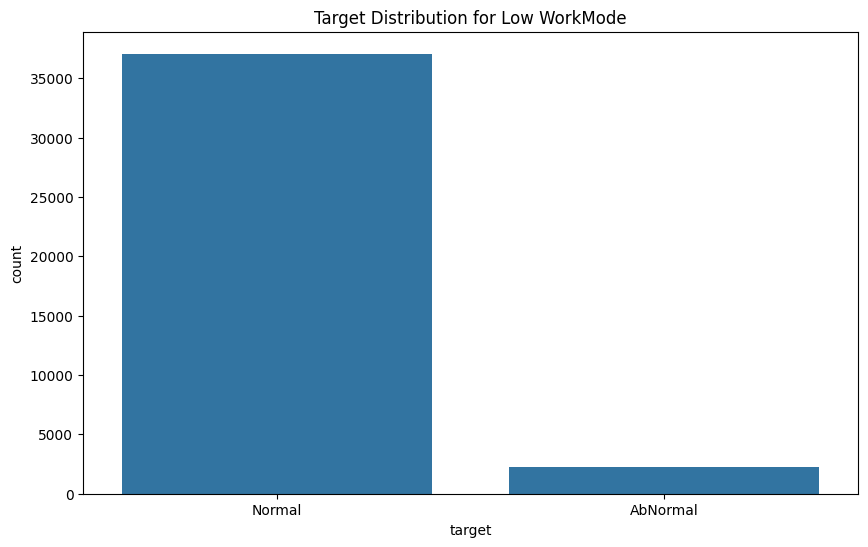

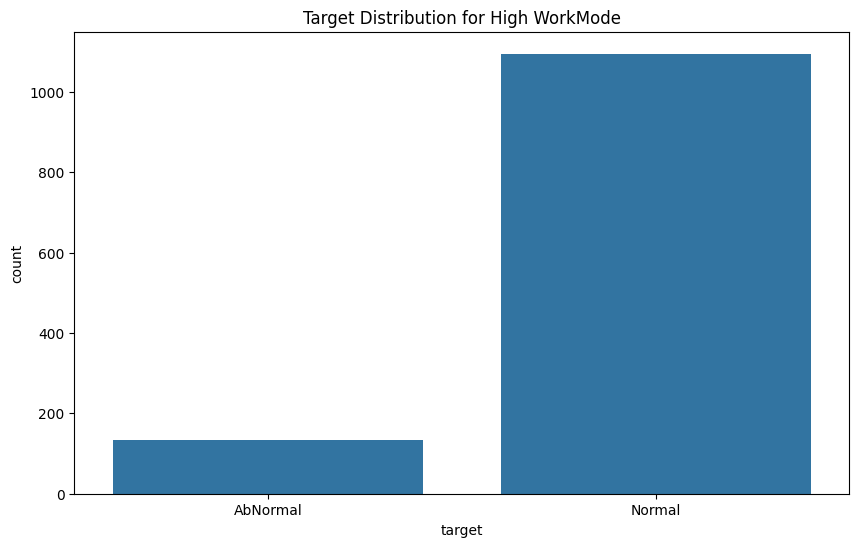

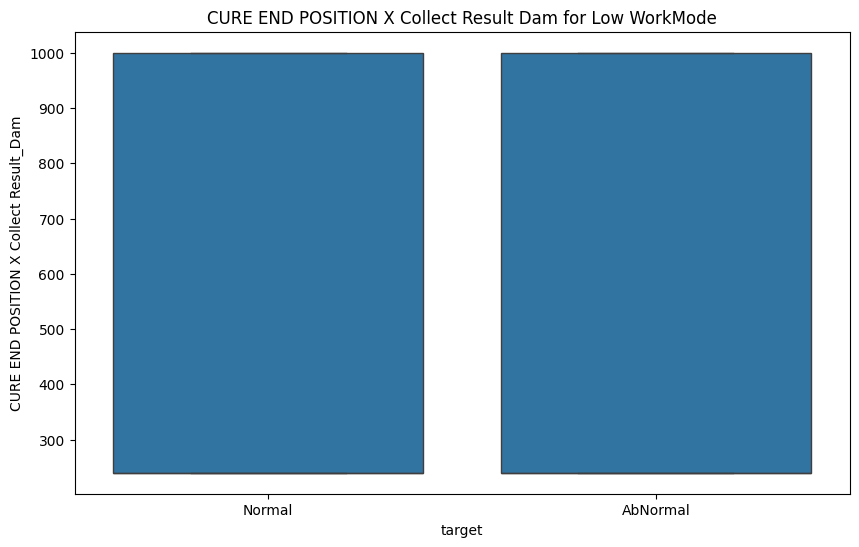

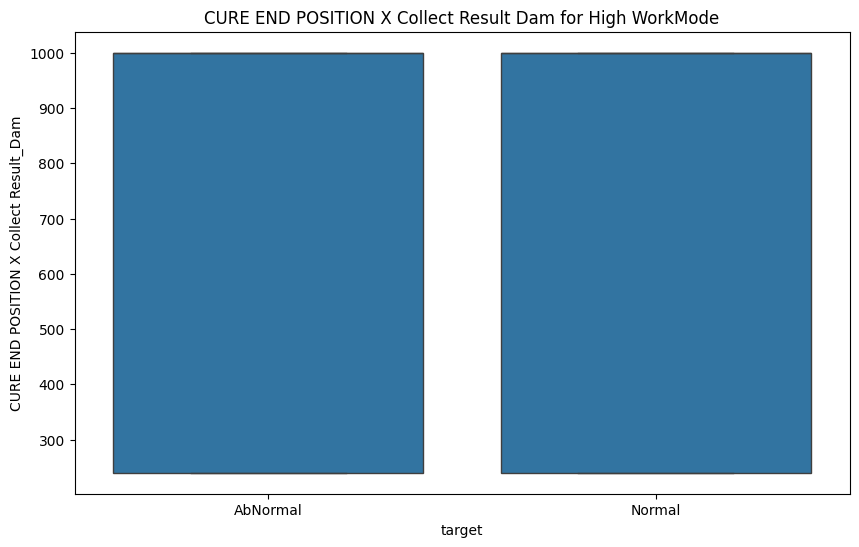

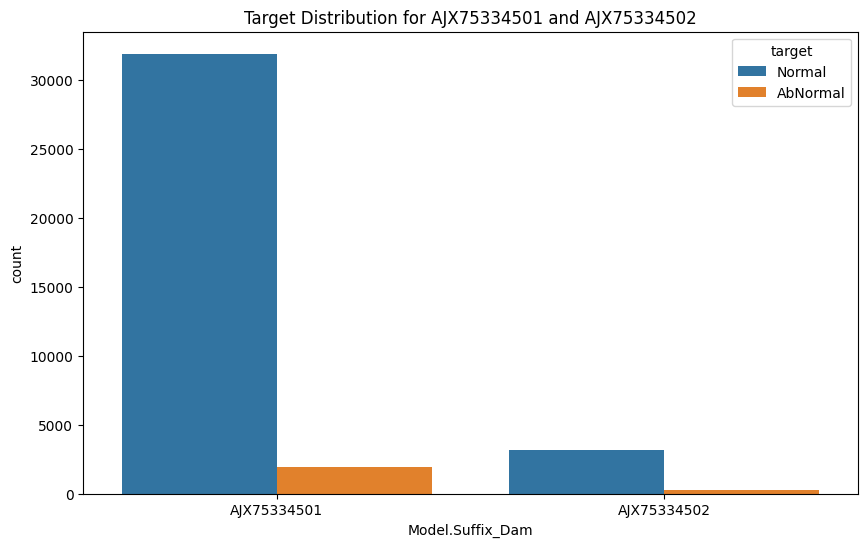

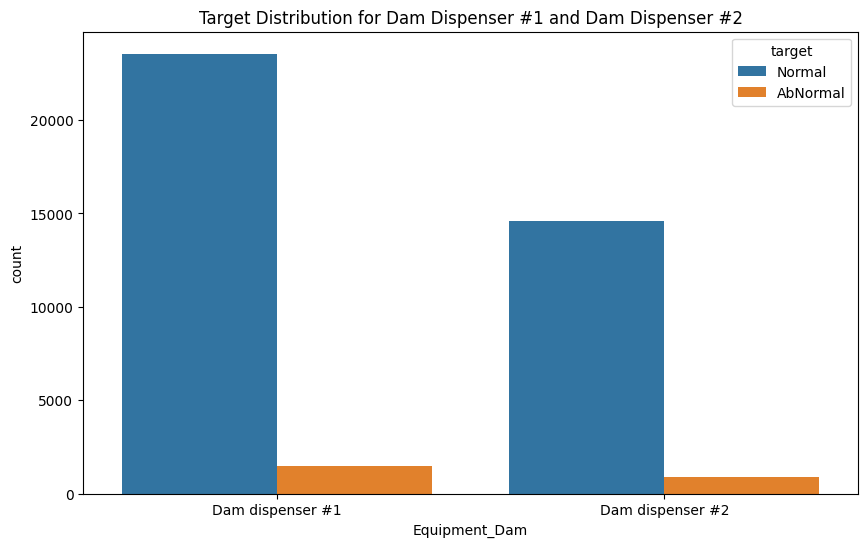

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming train_data is already loaded as a DataFrame

# 작업 모드가 높은 경우와 낮은 경우에 다른 변수들의 영향을 분석
# WorkMode가 높은 경우와 낮은 경우를 구분하여 분석

# 임계값을 설정하여 작업 모드를 높은 값과 낮은 값으로 나눕니다. 예: 중간값을 기준으로 구분
median_workmode = train_data['WorkMode Collect Result_Fill2'].median()

# 작업 모드가 낮은 경우
low_workmode = train_data[train_data['WorkMode Collect Result_Fill2'] <= median_workmode]

# 작업 모드가 높은 경우
high_workmode = train_data[train_data['WorkMode Collect Result_Fill2'] > median_workmode]

# 작업 모드가 낮은 경우와 높은 경우에 대한 target 분포 비교
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=low_workmode)
plt.title('Target Distribution for Low WorkMode')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=high_workmode)
plt.title('Target Distribution for High WorkMode')
plt.show()

# 작업 모드가 높은 경우와 낮은 경우에 CURE END POSITION X Collect Result Dam 변수와의 상관관계 분석
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='CURE END POSITION X Collect Result_Dam', data=low_workmode)
plt.title('CURE END POSITION X Collect Result Dam for Low WorkMode')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='CURE END POSITION X Collect Result_Dam', data=high_workmode)
plt.title('CURE END POSITION X Collect Result Dam for High WorkMode')
plt.show()

# 모델 간 불량 발생 패턴 비교
# AJX75334501과 AJX75334502 모델에 대한 target 분포 비교
model_specific_data = train_data[train_data['Model.Suffix_Dam'].isin(['AJX75334501', 'AJX75334502'])]

plt.figure(figsize=(10, 6))
sns.countplot(x='Model.Suffix_Dam', hue='target', data=model_specific_data)
plt.title('Target Distribution for AJX75334501 and AJX75334502')
plt.show()

# 장비 간 불량 발생 패턴 비교
# Dam dispenser #1과 Dam dispenser #2에 대한 target 분포 비교
plt.figure(figsize=(10, 6))
sns.countplot(x='Equipment_Dam', hue='target', data=train_data)
plt.title('Target Distribution for Dam Dispenser #1 and Dam Dispenser #2')
plt.show()


In [20]:
# 작업 모드가 높은 경우와 낮은 경우의 변수 간 상관관계 분석
numeric_columns = high_workmode.select_dtypes(include=['float64', 'int64']).columns
high_workmode_corr = high_workmode[numeric_columns].corr()
low_workmode_corr = low_workmode[numeric_columns].corr()

# 상관관계 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(high_workmode_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for High WorkMode')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(low_workmode_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Low WorkMode')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

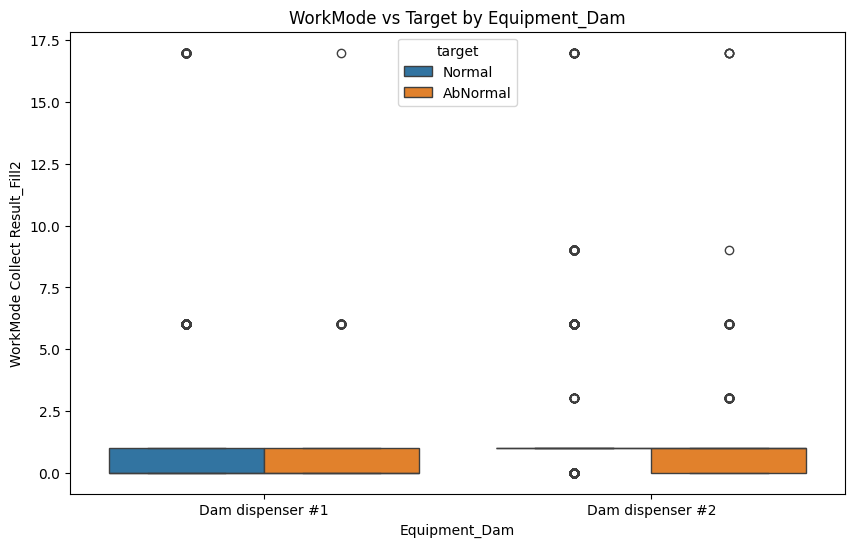

In [21]:
# 장비별로 작업 모드와 불량 발생 간의 관계 분석
plt.figure(figsize=(10, 6))
sns.boxplot(x='Equipment_Dam', y='WorkMode Collect Result_Fill2', hue='target', data=train_data)
plt.title('WorkMode vs Target by Equipment_Dam')
plt.show()


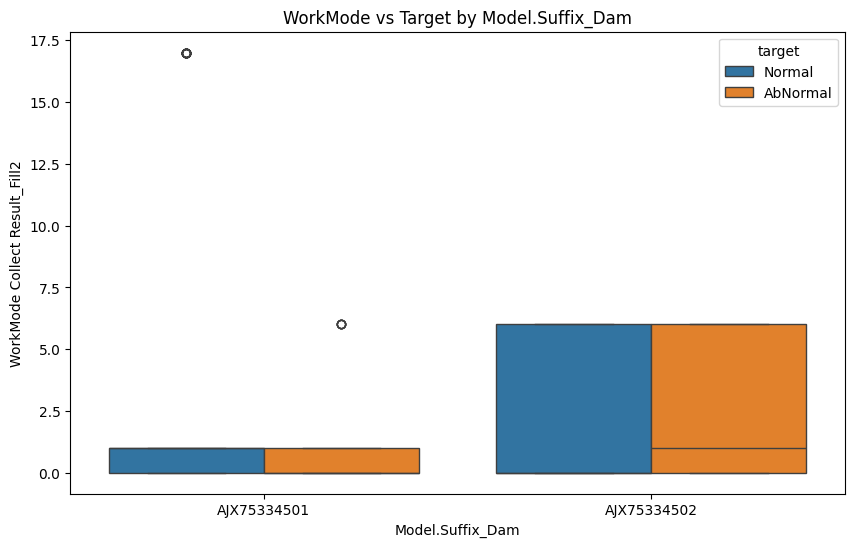

In [22]:
# 모델별로 불량 발생 원인 분석
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model.Suffix_Dam', y='WorkMode Collect Result_Fill2', hue='target', data=model_specific_data)
plt.title('WorkMode vs Target by Model.Suffix_Dam')
plt.show()


특정 장비, 모델별, 작업모드, 복합 요인으로 불량 발생에 미치는 영향 확인

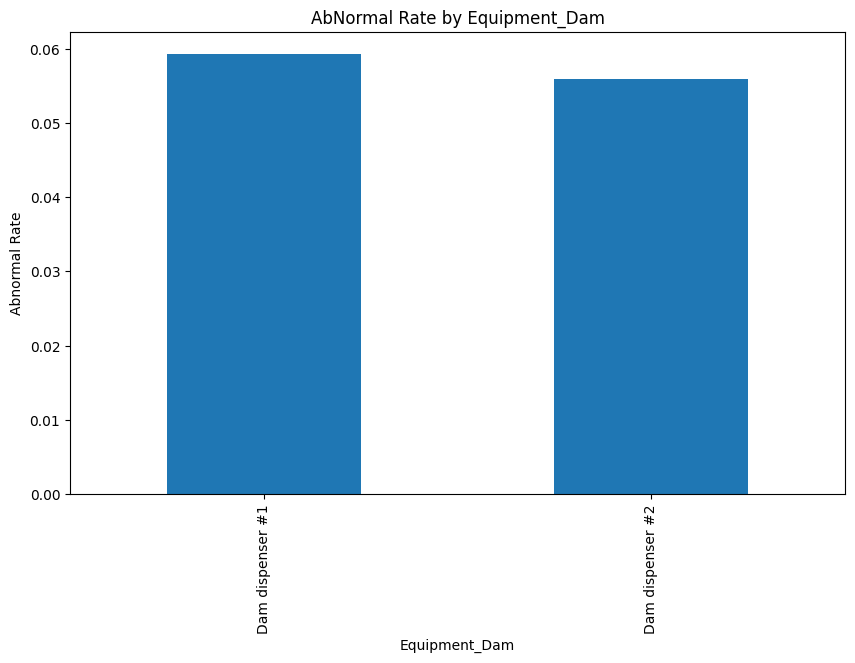

In [23]:
# 장비별 불량 발생 비율 계산
equipment_dam_abnormal_rate = train_data.groupby('Equipment_Dam')['target'].value_counts(normalize=True).unstack()['AbNormal']

# 불량 발생 비율 시각화
plt.figure(figsize=(10, 6))
equipment_dam_abnormal_rate.plot(kind='bar')
plt.title('AbNormal Rate by Equipment_Dam')
plt.ylabel('Abnormal Rate')
plt.show()


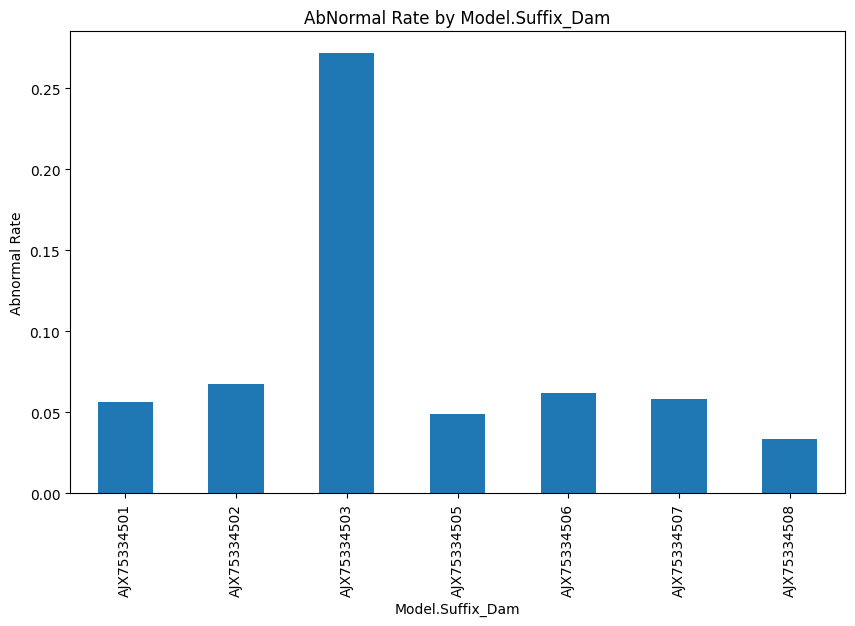

In [24]:
# 모델별 불량 발생 비율 계산
model_suffix_abnormal_rate = train_data.groupby('Model.Suffix_Dam')['target'].value_counts(normalize=True).unstack()['AbNormal']

# 불량 발생 비율 시각화
plt.figure(figsize=(10, 6))
model_suffix_abnormal_rate.plot(kind='bar')
plt.title('AbNormal Rate by Model.Suffix_Dam')
plt.ylabel('Abnormal Rate')
plt.show()


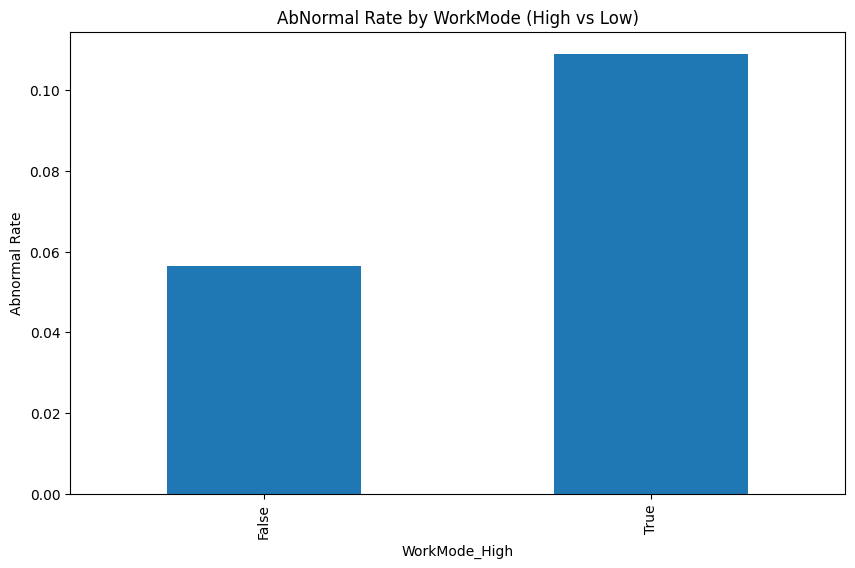

In [25]:
# 작업 모드별로 작업 모드 값을 이진화 (작업 모드의 중앙값을 기준으로 나눔)
median_workmode = train_data['WorkMode Collect Result_Fill2'].median()
train_data['WorkMode_High'] = train_data['WorkMode Collect Result_Fill2'] > median_workmode

# 작업 모드별 불량 발생 비율 계산
workmode_abnormal_rate = train_data.groupby('WorkMode_High')['target'].value_counts(normalize=True).unstack()['AbNormal']

# 불량 발생 비율 시각화
plt.figure(figsize=(10, 6))
workmode_abnormal_rate.plot(kind='bar')
plt.title('AbNormal Rate by WorkMode (High vs Low)')
plt.ylabel('Abnormal Rate')
plt.show()


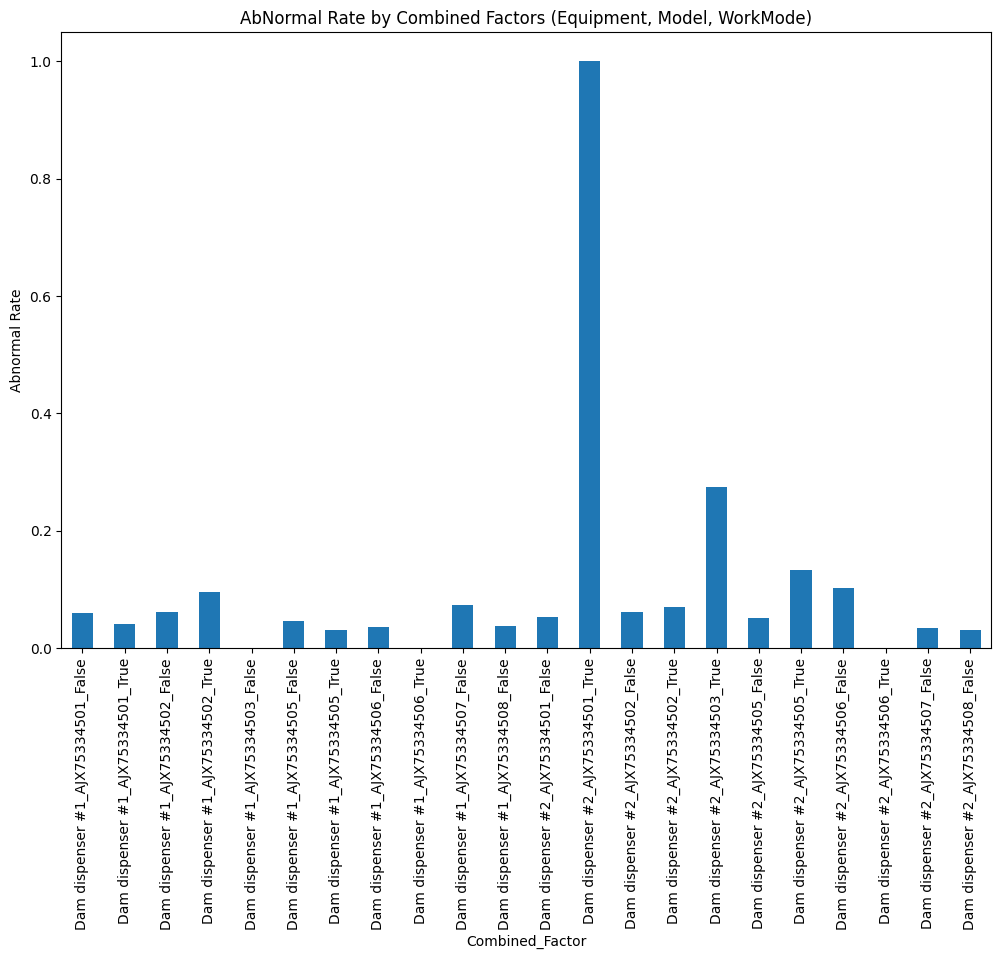

In [26]:
# 복합 요인 분석: 장비, 모델, 작업 모드를 결합하여 불량 발생 비율 계산
train_data['Combined_Factor'] = train_data['Equipment_Dam'] + '_' + train_data['Model.Suffix_Dam'] + '_' + train_data['WorkMode_High'].astype(str)

combined_abnormal_rate = train_data.groupby('Combined_Factor')['target'].value_counts(normalize=True).unstack()['AbNormal']

# 불량 발생 비율 시각화
plt.figure(figsize=(12, 8))
combined_abnormal_rate.plot(kind='bar')
plt.title('AbNormal Rate by Combined Factors (Equipment, Model, WorkMode)')
plt.ylabel('Abnormal Rate')
plt.show()


이 그래프는 장비(Dam dispenser), 모델, 그리고 작업 모드(WorkMode)를 결합한 변수(Combined_Factor)에 따른 불량 발생 비율을 보여줍니다. 여기서 특정 조합, 특히 Dam dispenser #2, AJX75334501, True (작업 모드가 높은 경우)에서 불량 비율이 매우 높게 나타나는 것을 확인할 수 있습니다. 이는 이 조합에서 불량이 발생할 가능성이 더 높음을 의미합니다.
-> 이 조합에 대한 공정 개선이 필요

Dam dispenser #1에서 더 높은 불량 발생 비율을 보이는데, 왜 Dam dispenser #2에서 작업 모드가 높아질수록 불량 발생 비율이 증가한다고 해석되는가?

이 질문에 대한 답변은 다음과 같습니다:

작업 모드에 따른 불량 발생 비율 증가는 Dam dispenser #2에서 작업 모드가 높아질 때 특정 조건에서 불량 발생 비율이 급격히 증가하는 경향을 보일 수 있습니다. 즉, Dam dispenser #2 자체는 Dam dispenser #1에 비해 전체적으로 불량률이 낮더라도, 작업 모드가 높은 경우에는 불량 발생에 더 민감하게 반응할 수 있다는 것입니다.
그래프 간의 해석 차이는 작업 모드와 장비 간의 상호작용을 고려한 것

<ipython-input-27-064a2ecf5208>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(x='WorkMode_High', y='target', hue='Equipment_Dam', kind='bar', data=train_data, ci=None)


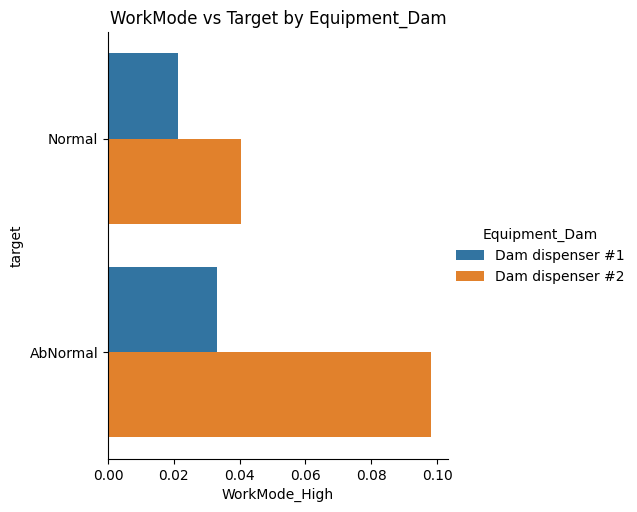

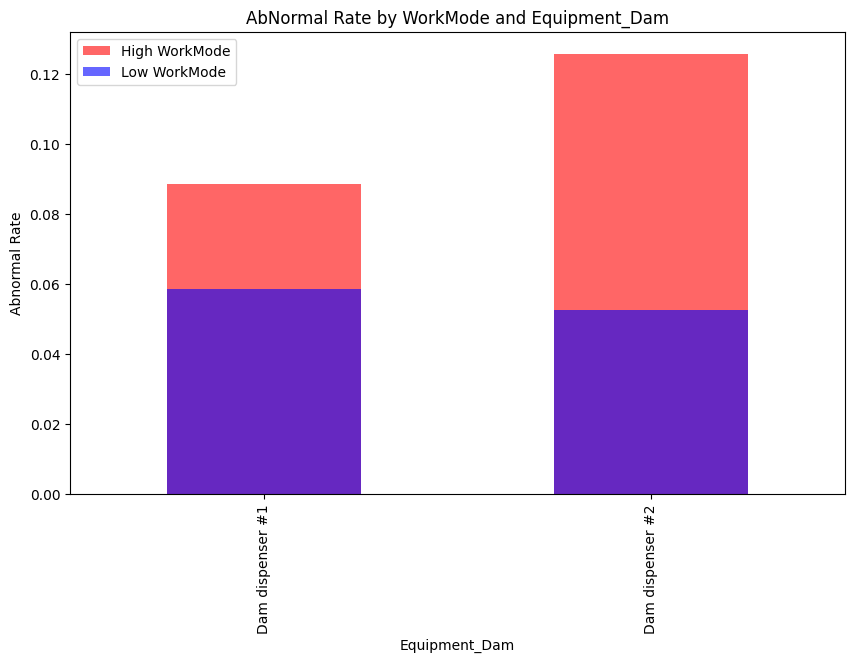

In [27]:
# 작업 모드와 장비 간의 상호작용을 분석하여 불량 발생 비율 계산
sns.catplot(x='WorkMode_High', y='target', hue='Equipment_Dam', kind='bar', data=train_data, ci=None)
plt.title('WorkMode vs Target by Equipment_Dam')
plt.show()

# 작업 모드가 높을 때와 낮을 때, 각 장비에서의 불량 발생 비율 비교
workmode_high_abnormal_rate = train_data[train_data['WorkMode_High'] == True].groupby('Equipment_Dam')['target'].value_counts(normalize=True).unstack()['AbNormal']
workmode_low_abnormal_rate = train_data[train_data['WorkMode_High'] == False].groupby('Equipment_Dam')['target'].value_counts(normalize=True).unstack()['AbNormal']

# 작업 모드가 높을 때와 낮을 때 불량 발생 비율 비교 시각화
plt.figure(figsize=(10, 6))
workmode_high_abnormal_rate.plot(kind='bar', color='red', alpha=0.6, label='High WorkMode')
workmode_low_abnormal_rate.plot(kind='bar', color='blue', alpha=0.6, label='Low WorkMode')
plt.title('AbNormal Rate by WorkMode and Equipment_Dam')
plt.ylabel('Abnormal Rate')
plt.legend()
plt.show()


 Dam dispenser #2에서 작업 모드가 높아질 때 불량 발생이 더 자주 발생한다는 것. 이는 특정 장비와 작업 모드가 결합된 상황에서 불량 발생이 급격히 증가할 수 있음을 보여줌.

In [29]:
import pandas as pd

# 불량률 계산 함수
def calculate_failure_rate(df, target_col, feature):
    failure_rate = df.groupby(feature)[target_col].value_counts(normalize=True).unstack().fillna(0)  # 불량률(AbNormal 비율) 계산
    if 'AbNormal' in failure_rate.columns:
        return failure_rate['AbNormal']
    else:
        return None

# 불량률이 높은 컬럼들 탐색
threshold = 0.1  # 불량률이 10% 이상인 경우에 관심
high_failure_features = {}

for col in train_data.columns:
    if col not in ['target']:  # 타겟 변수는 제외
        failure_rate = calculate_failure_rate(train_data, 'target', col)
        if failure_rate is not None and failure_rate.max() > threshold:
            high_failure_features[col] = failure_rate

# 결과 출력
for feature, rate in high_failure_features.items():
    print(f"Feature: {feature}")
    print(rate.sort_values(ascending=False).head())  # 불량률 상위 5개 값 출력


Feature: Model.Suffix_Dam
Model.Suffix_Dam
AJX75334503    0.271605
AJX75334502    0.067847
AJX75334506    0.062016
AJX75334507    0.058065
AJX75334501    0.056712
Name: AbNormal, dtype: float64
Feature: Workorder_Dam
Workorder_Dam
3KPXX094-0001    1.000000
4CPXX084-0001    1.000000
3H1XE354-1       0.866667
4E1XA548-2       0.666667
4A1XC288-1       0.500000
Name: AbNormal, dtype: float64
Feature: DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Dam
15    0.250000
10    0.066806
16    0.048468
Name: AbNormal, dtype: float64
Feature: DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
11.6    0.113208
9.6     0.092846
13.7    0.090909
9.7     0.076994
14.3    0.068966
Name: AbNormal, dtype: float64
Feature: DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
5.9    0.500000
5.8    0.333333
7.9    0.166667
4.8    0.099415
3.9    0.087009
Name: AbNor

1. 전체적인 경향 분석
Model.Suffix_Dam, Workorder_Dam, DISCHARGED SPEED OF RESIN Collect Result_Dam, DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam 등 다양한 컬럼에서 특정 값에서 불량률이 높게 나타나는 것을 확인할 수 있습니다.
예를 들어, Model.Suffix_Dam에서 AJX75334503의 불량률이 약 27%로 다른 값들에 비해 상당히 높은 것을 확인할 수 있습니다.
또한, Workorder_Dam에서는 특정 작업 번호에서 100% 불량률이 발생하는 등, 매우 강한 불량 발생 패턴을 보이는 경우도 있습니다.
2. 불량률이 높은 주요 패턴들
모델 관련 패턴: Model.Suffix_Dam 및 관련된 Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2에서도 불량률이 높은 패턴을 확인할 수 있습니다. 특히, AJX75334503 모델이 여러 공정 단계에서 높은 불량률을 보이는 것을 확인할 수 있습니다.
작업 순서 관련 패턴: Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2에서도 특정 작업 순서에서 매우 높은 불량률을 보이고 있습니다. 이는 특정 작업 순서가 불량 발생에 강하게 연관되어 있을 가능성을 시사합니다.
레진 배출 속도 및 시간 관련 패턴: DISCHARGED SPEED OF RESIN Collect Result_Dam, DISCHARGED TIME OF RESIN 관련 컬럼들에서도 불량률이 높은 특정 값을 확인할 수 있습니다. 이는 레진 배출 과정에서의 변수들이 불량 발생에 중요한 역할을 할 수 있음을 나타냅니다.
3. 주요 피처 해석
Model.Suffix_Dam: 특정 모델(AJX75334503)에서 높은 불량률을 보임. 이는 이 모델의 특정 설계나 제조 공정에서 문제가 있을 가능성을 시사합니다.
Workorder_Dam: 특정 작업 순서에서 불량률이 매우 높게 나타남. 이는 해당 작업에서의 공정 관리에 문제가 있거나, 작업 순서 자체에 문제가 있을 수 있음을 나타냅니다.
DISCHARGED SPEED/TIME OF RESIN: 레진 배출 속도 및 시간이 불량률에 크게 영향을 미치고 있습니다. 특히, DISCHARGED SPEED OF RESIN Collect Result_Dam에서 15 값에서 25%의 불량률을 보이고, 다른 값들에 비해 상대적으로 높은 불량률을 보이는 것을 알 수 있습니다.
4. 결론 및 추가 분석 방향
특정 모델과 작업 순서에 대한 세부 분석: AJX75334503 모델과 특정 작업 순서에 대한 추가적인 심층 분석이 필요합니다. 이들 변수는 불량 발생에 중요한 역할을 하고 있기 때문에, 공정 개선의 주요 타겟이 될 수 있습니다.
레진 배출 관련 공정 개선: 레진 배출 속도 및 시간이 불량 발생에 중요한 요인으로 작용하고 있습니다. 이 공정을 개선함으로써 불량률을 낮출 수 있는 가능성이 있습니다.
고위험 조합에 대한 추가 피처 생성: 불량률이 높은 피처들을 조합하여 추가적인 피처를 생성하고, 이를 모델링에 반영할 수 있습니다.

<Figure size 1000x600 with 0 Axes>

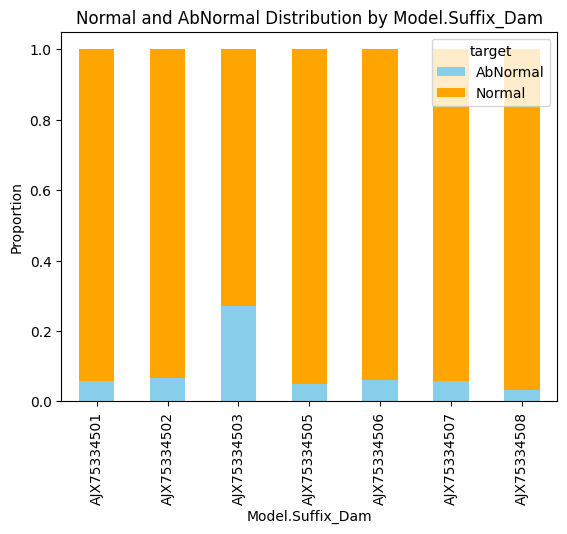

<Figure size 1000x600 with 0 Axes>

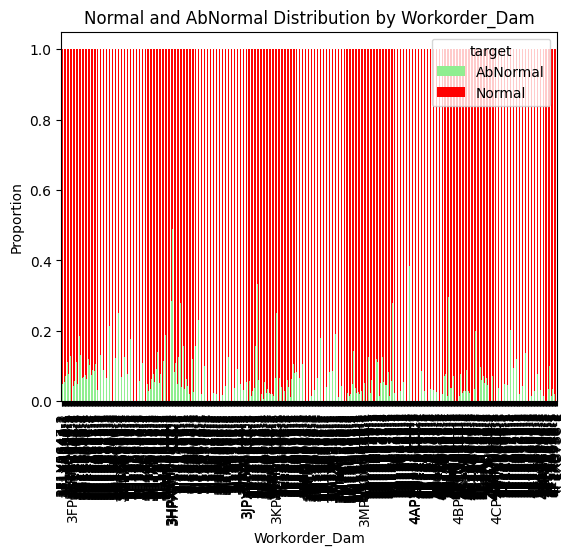

<Figure size 1000x600 with 0 Axes>

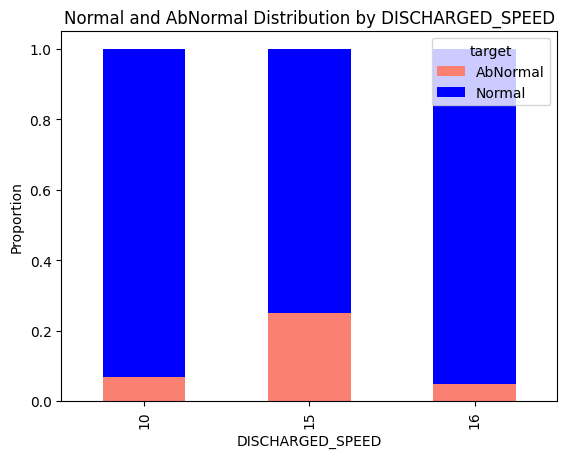

In [23]:
import matplotlib.pyplot as plt

# Model.Suffix_Dam에 따른 Normal과 Abnormal의 분포 계산
model_suffix_distribution = train_data.groupby('Model.Suffix_Dam')['target'].value_counts(normalize=True).unstack()

# Normal과 Abnormal 분포 시각화
plt.figure(figsize=(10, 6))
model_suffix_distribution.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Normal and AbNormal Distribution by Model.Suffix_Dam')
plt.ylabel('Proportion')
plt.xlabel('Model.Suffix_Dam')
plt.show()

# Workorder_Dam에 따른 Normal과 Abnormal의 분포 계산
workorder_distribution = train_data.groupby('Workorder_Dam')['target'].value_counts(normalize=True).unstack()

# Normal과 Abnormal 분포 시각화
plt.figure(figsize=(10, 6))
workorder_distribution.plot(kind='bar', stacked=True, color=['lightgreen', 'red'])
plt.title('Normal and AbNormal Distribution by Workorder_Dam')
plt.ylabel('Proportion')
plt.xlabel('Workorder_Dam')
plt.show()

# DISCHARGED_SPEED에 따른 Normal과 Abnormal의 분포 계산
discharged_speed_distribution = train_data.groupby('DISCHARGED SPEED OF RESIN Collect Result_Dam')['target'].value_counts(normalize=True).unstack()

# Normal과 Abnormal 분포 시각화
plt.figure(figsize=(10, 6))
discharged_speed_distribution.plot(kind='bar', stacked=True, color=['salmon', 'blue'])
plt.title('Normal and AbNormal Distribution by DISCHARGED_SPEED')
plt.ylabel('Proportion')
plt.xlabel('DISCHARGED_SPEED')
plt.show()


<Figure size 1000x600 with 0 Axes>

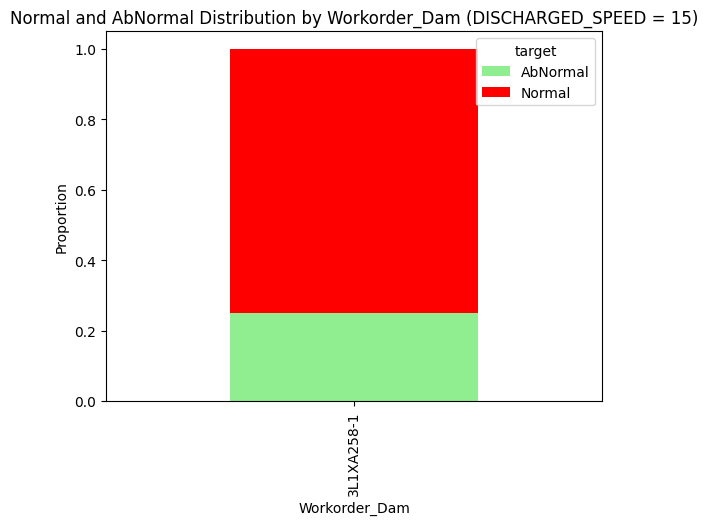

<Figure size 1000x600 with 0 Axes>

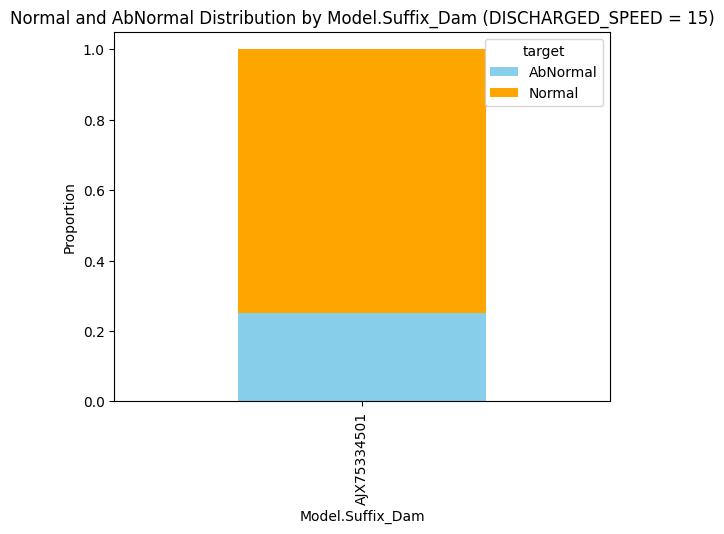

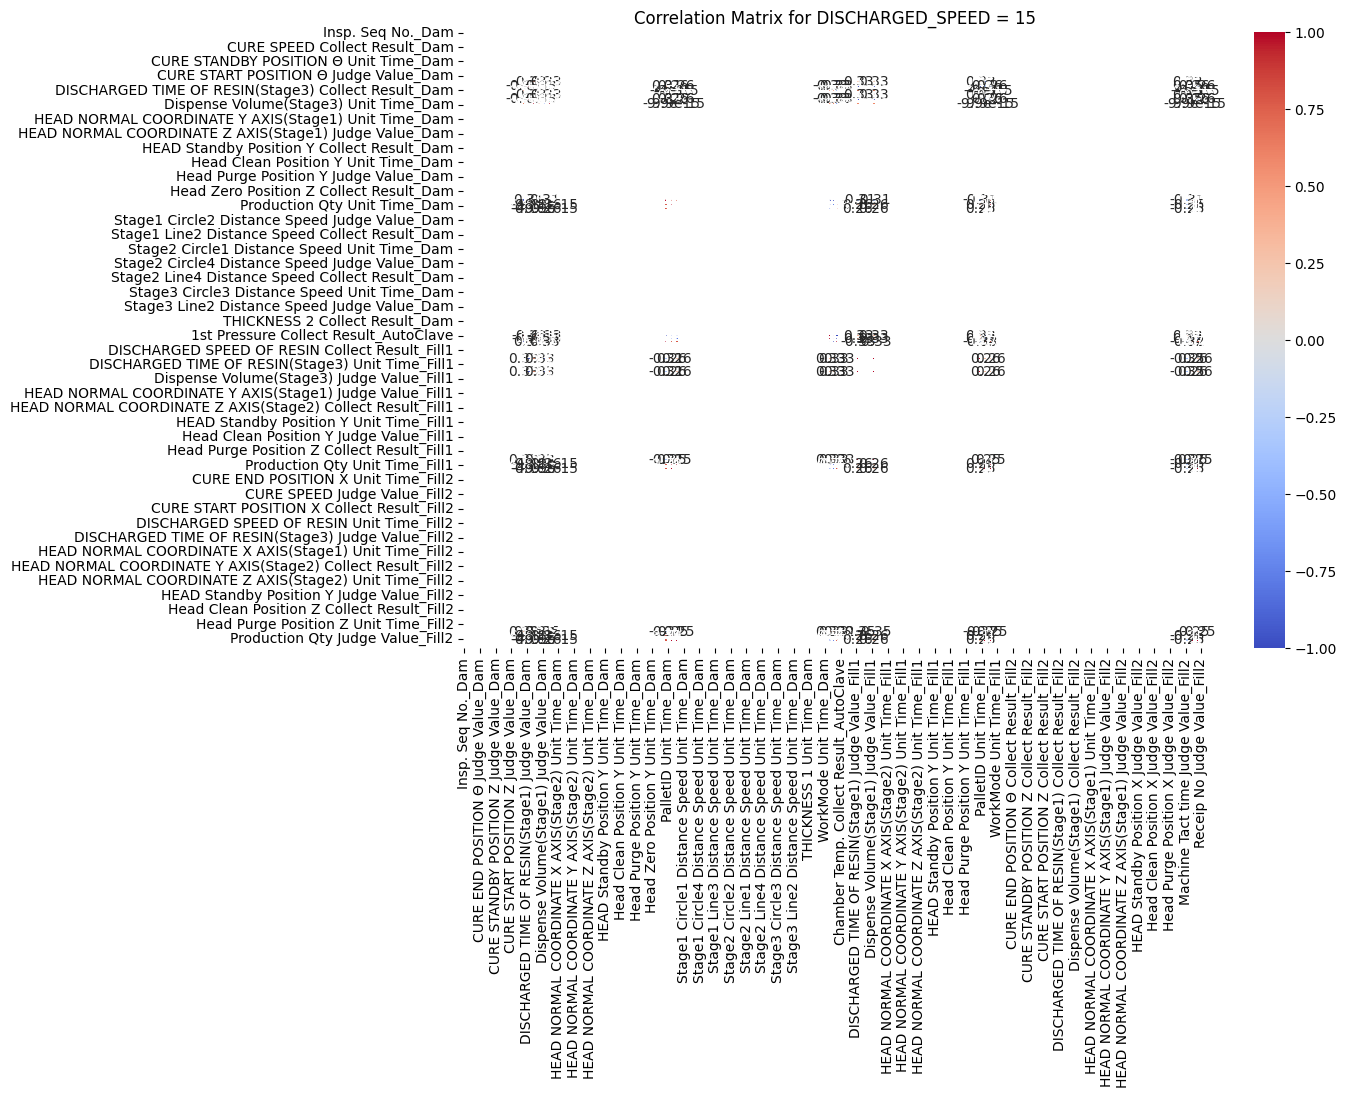

In [26]:
# DISCHARGED_SPEED가 15인 데이터 필터링
speed_15_data = train_data[train_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'] == 15]

# 필터링된 데이터의 요약 통계
speed_15_summary = speed_15_data.describe()

# 필터링된 데이터에서 target과 관련된 변수들 분석
speed_15_target_distribution = speed_15_data['target'].value_counts(normalize=True)

# DISCHARGED_SPEED가 15일 때 다른 변수와의 관계 시각화 (예: Workorder_Dam)
plt.figure(figsize=(10, 6))
workorder_distribution_speed_15 = speed_15_data.groupby('Workorder_Dam')['target'].value_counts(normalize=True).unstack()
workorder_distribution_speed_15.plot(kind='bar', stacked=True, color=['lightgreen', 'red'])
plt.title('Normal and AbNormal Distribution by Workorder_Dam (DISCHARGED_SPEED = 15)')
plt.ylabel('Proportion')
plt.xlabel('Workorder_Dam')
plt.show()

# DISCHARGED_SPEED가 15일 때 발생한 다른 변수들과의 관계 분석
# 예시로 'Model.Suffix_Dam'와의 관계 분석
plt.figure(figsize=(10, 6))
model_suffix_distribution_speed_15 = speed_15_data.groupby('Model.Suffix_Dam')['target'].value_counts(normalize=True).unstack()
model_suffix_distribution_speed_15.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Normal and AbNormal Distribution by Model.Suffix_Dam (DISCHARGED_SPEED = 15)')
plt.ylabel('Proportion')
plt.xlabel('Model.Suffix_Dam')
plt.show()

# 추가적인 상관관계 분석 (예시)
numeric_data_speed_15 = speed_15_data.select_dtypes(include=[float, int])

correlation_matrix_speed_15 = numeric_data_speed_15.corr()

import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_speed_15, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for DISCHARGED_SPEED = 15')
plt.show()


현재 상황에서 DISCHARGED_SPEED가 15일 때 특정 모델과 작업 명령이 하나씩밖에 없다는 것은 데이터가 매우 구체적인 상황에서 불량률이 높게 나타나고 있다는 것을 의미합니다. 이러한 경우, 해당 조건에서 다른 변수를 고려하여 추가 분석을 수행하는 것이 중요합니다.

모델별 데이터 분포:
 Model.Suffix_Dam
AJX75334501    4
Name: count, dtype: int64

작업 명령별 데이터 분포:
 Workorder_Dam
3L1XA258-1    4
Name: count, dtype: int64


<ipython-input-30-b6bde24055f4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_15_data['Abnormal'] = speed_15_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)


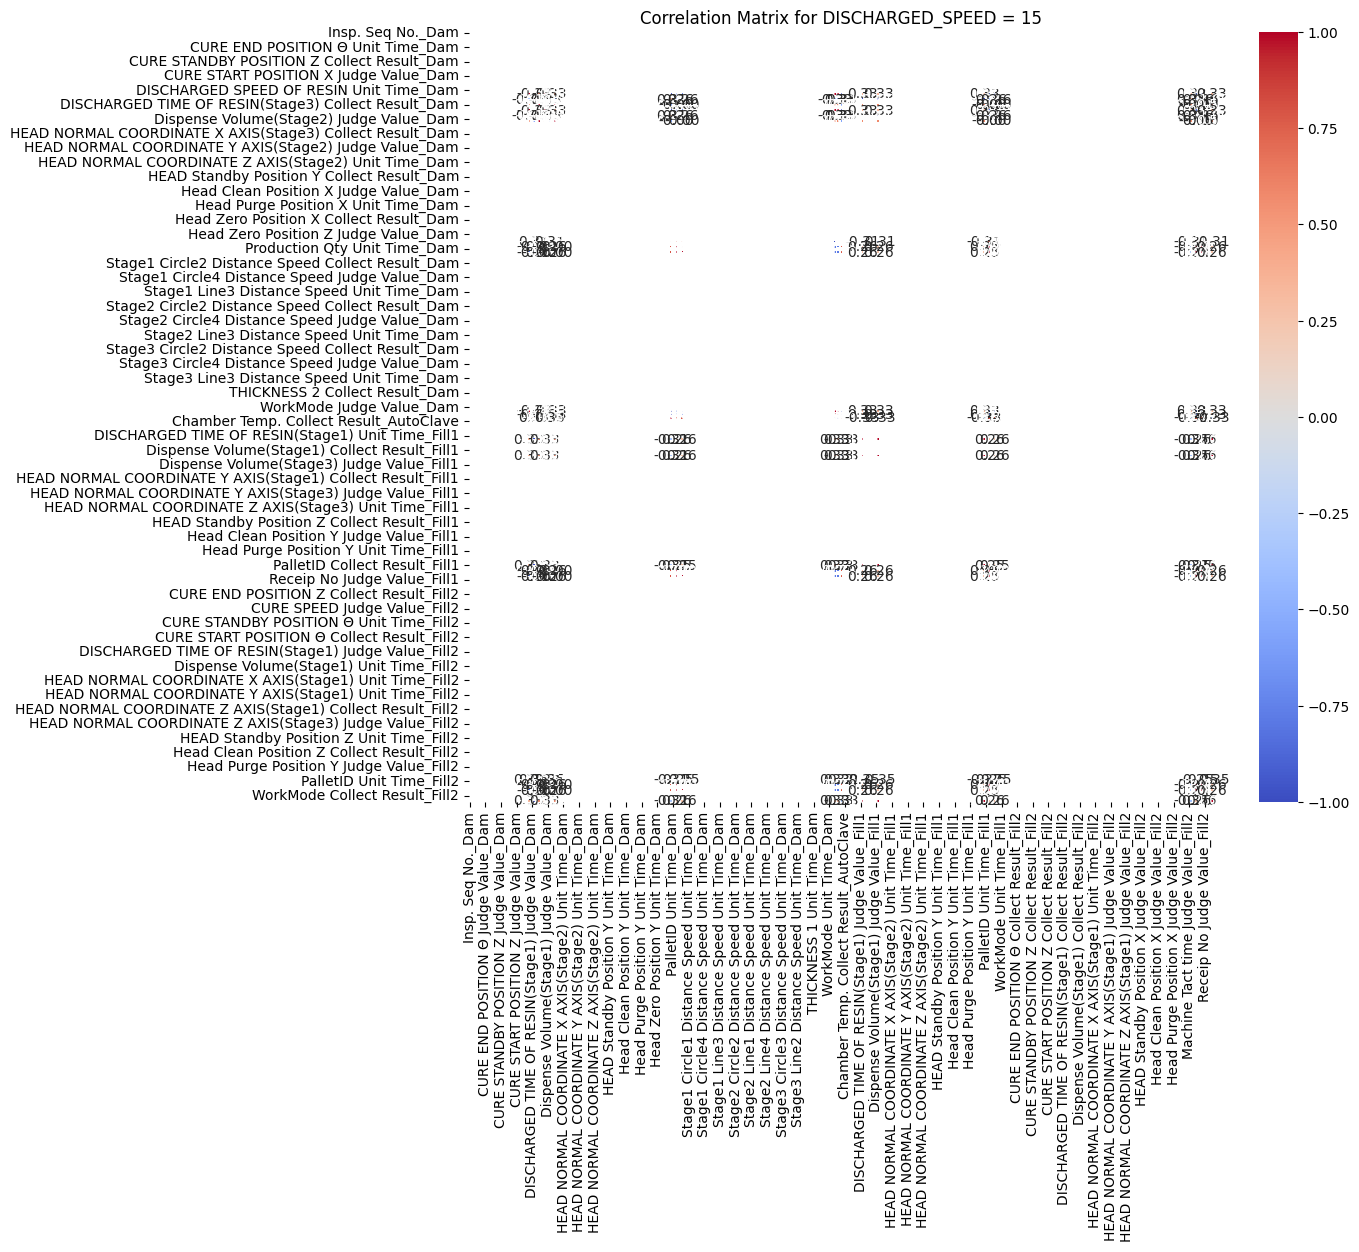

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


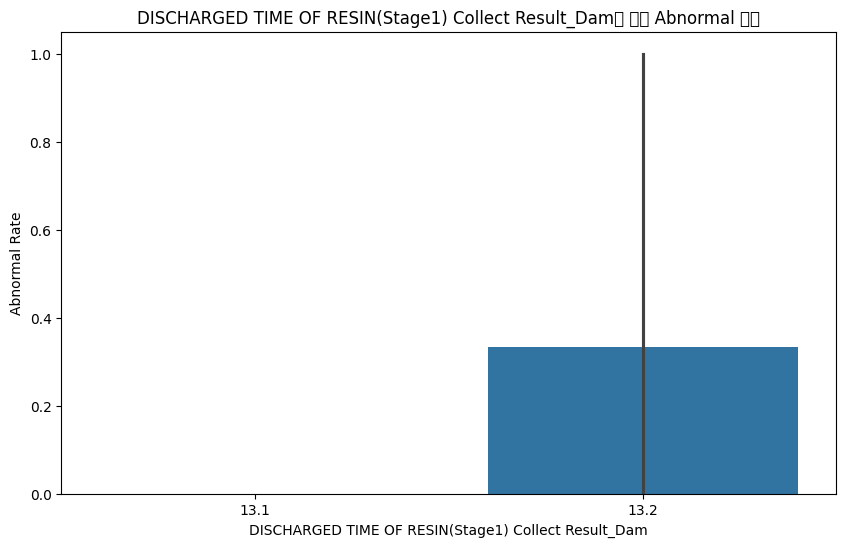

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


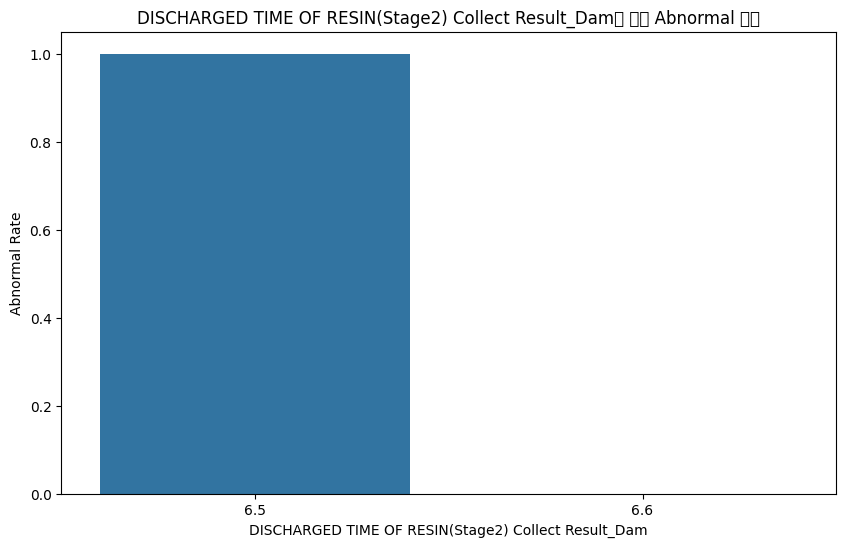

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DISCHARGED_SPEED가 15인 데이터 필터링
speed_15_data = train_data[train_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'] == 15]

# 모델별, 작업 명령별 데이터 확인
print("모델별 데이터 분포:\n", speed_15_data['Model.Suffix_Dam'].value_counts())
print("\n작업 명령별 데이터 분포:\n", speed_15_data['Workorder_Dam'].value_counts())

# Abnormal 값을 1로 변환, 나머지는 0으로 변환
speed_15_data['Abnormal'] = speed_15_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)

# 숫자형 변수만 추출
numeric_cols = speed_15_data.select_dtypes(include=['float64', 'int64']).columns

# 범주형 변수를 숫자로 인코딩
encoded_data = speed_15_data.copy()
for col in speed_15_data.select_dtypes(include=['object']).columns:
    encoded_data[col] = encoded_data[col].astype('category').cat.codes

# 상관관계 분석 시각화 (숫자형 데이터만 사용)
plt.figure(figsize=(12, 10))
sns.heatmap(encoded_data[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for DISCHARGED_SPEED = 15')
plt.show()

# 다른 공정 변수에 따른 Abnormal 비율 시각화
process_variables = ['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']

for var in process_variables:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=var, y='Abnormal', data=speed_15_data)
    plt.title(f'{var}에 따른 Abnormal 비율')
    plt.xlabel(var)
    plt.ylabel('Abnormal Rate')
    plt.show()


DISCHARGED TIME OF RESIN(Stage1)과 Abnormal 비율:

13.1에서 13.2로 갈 때, Abnormal 비율이 증가하는 것으로 보입니다. 이는 이 구간에서 공정 시간이 증가함에 따라 불량률이 증가할 가능성이 있다는 것을 시사합니다.
DISCHARGED TIME OF RESIN(Stage2)과 Abnormal 비율:

6.5에서 6.6으로 갈 때, 모든 데이터 포인트가 Abnormal로 나타나고 있습니다. 이 구간에서의 공정 시간은 거의 모든 경우에 불량을 발생시킬 가능성이 큽니다.

## 데이터전처리

In [7]:

# Drop columns with common NaNs
nan_columns_train = train_data.columns[train_data.isna().any()].tolist()
nan_columns_test = test_data.columns[test_data.isna().any()].tolist()
common_nan_columns = list(set(nan_columns_train) & set(nan_columns_test))
train_data = train_data.drop(columns=common_nan_columns)
test_data = test_data.drop(columns=common_nan_columns)

# Split features and target
train_x = train_data.drop(columns=["target"])
train_y = train_data["target"]
test_x = test_data.drop(columns=["Set ID", "target"], errors='ignore')
test_set_id = test_data['Set ID']  # Save the Set ID column

# Separate numeric and categorical columns
numeric_cols = train_x.select_dtypes(include=['number']).columns
categorical_cols = train_x.select_dtypes(include=['object']).columns

# Fill missing values
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_x[numeric_cols] = numeric_imputer.fit_transform(train_x[numeric_cols])
test_x[numeric_cols] = numeric_imputer.transform(test_x[numeric_cols])
train_x[categorical_cols] = categorical_imputer.fit_transform(train_x[categorical_cols])
test_x[categorical_cols] = categorical_imputer.transform(test_x[categorical_cols])

# Encode categorical variables
def preprocess_data(df, categorical_cols):
    label_encoders = {}
    for column in categorical_cols:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df

train_x = preprocess_data(train_x, categorical_cols)
test_x = preprocess_data(test_x, categorical_cols)

# Scaling features
scaler = StandardScaler()
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns)

## 오버샘플링

In [8]:
# Balancing dataset using SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
train_x, train_y = smote.fit_resample(train_x, train_y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_x, train_y, test_size=0.3, stratify=train_y, random_state=RANDOM_STATE
)

In [9]:
pip install imbalanced-learn

## 모델 정의

In [10]:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import classification_report, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 사용할 모델 리스트 정의
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
#     "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
#     "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
#     "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
#     "SVM": SVC(random_state=RANDOM_STATE),
#     "K-Nearest Neighbors": KNeighborsClassifier(),
# }

# # 모델별 성능을 저장할 리스트 초기화
# model_performance = []

# # 각 모델에 대해 학습 및 평가 수행
# for model_name, model in models.items():
#     print(f"Training {model_name}...")
#     model.fit(X_train, y_train)
#     val_predictions = model.predict(X_val)

#     f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
#     model_performance.append({"Model": model_name, "F1 Score": f1})

#     print(f"{model_name} F1 Score: {f1:.4f}")
#     print(classification_report(y_val, val_predictions))

#     # Confusion Matrix 시각화
#     cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title(f"{model_name} Confusion Matrix")
#     plt.show()

# # 모델별 F1 점수 비교
# performance_df = pd.DataFrame(model_performance)
# performance_df = performance_df.sort_values(by="F1 Score", ascending=False)

# plt.figure(figsize=(10, 6))
# sns.barplot(x="F1 Score", y="Model", data=performance_df, palette="viridis")
# plt.title("Model Comparison by F1 Score")
# plt.show()

Voting Classifier F1 Score: 0.9676

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.97      0.97      0.97     11447
      Normal       0.97      0.97      0.97     11447

    accuracy                           0.97     22894
   macro avg       0.97      0.97      0.97     22894
weighted avg       0.97      0.97      0.97     22894



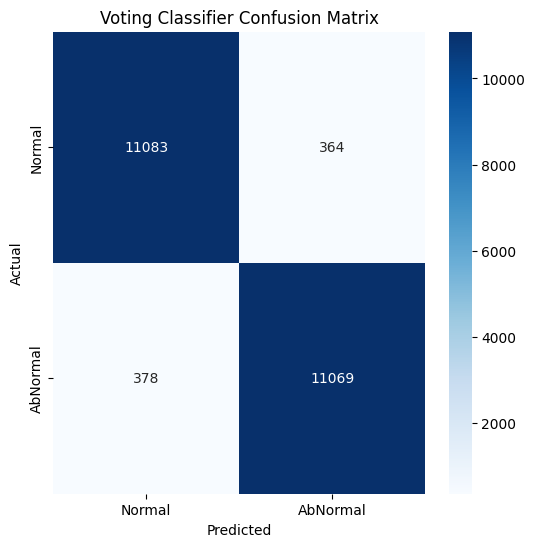

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest, Gradient Boosting, KNN 모델 정의
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
knn_model = KNeighborsClassifier()

# Voting Classifier 정의 (소프트 보팅 방식)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('knn', knn_model)
], voting='soft')  # 'soft' 보팅을 사용해 모델의 확률을 기반으로 예측

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 검증 데이터로 예측 수행
val_predictions = voting_clf.predict(X_val)

# F1 Score 계산
f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
print(f"Voting Classifier F1 Score: {f1:.4f}")

# Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))

# Confusion Matrix 시각화
cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Voting Classifier Confusion Matrix")
plt.show()


In [12]:
# ### 모델 정의 및 학습
# model = RandomForestClassifier(random_state=RANDOM_STATE)
# model.fit(X_train, y_train)

# ### 모델 평가

# # Make predictions
# val_predictions = model.predict(X_val)

# # Evaluate the model
# f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
# print(f"F1 Score: {f1:.4f}")

# print("\nClassification Report:")
# print(classification_report(y_val, val_predictions))

# # Confusion Matrix 시각화
# cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# ### Feature Importance 시각화
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]

# # Plot feature importances
# plt.figure(figsize=(12, 6))
# plt.title("Feature Importance")
# plt.bar(range(X_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
# plt.tight_layout()
# plt.show()


In [13]:

# ### 모델 정의 및 하이퍼파라미터 튜닝
# # RandomForest 하이퍼파라미터 튜닝
# rf_params = {
#     'n_estimators': [100, 300],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
# rf_grid = GridSearchCV(rf_model, rf_params, cv=StratifiedKFold(5), n_jobs=-1, scoring='f1', verbose=1)
# rf_grid.fit(X_train, y_train)

# print(f"Best RandomForest Parameters: {rf_grid.best_params_}")
# best_rf_model = rf_grid.best_estimator_

# # GradientBoosting 모델 정의
# gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)

# # 앙상블 모델 (Voting Classifier) 정의
# ensemble_model = VotingClassifier(estimators=[
#     ('rf', best_rf_model),
#     ('gb', gb_model)
# ], voting='soft')

# # 모델 학습
# ensemble_model.fit(X_train, y_train)

# ### 모델 평가
# val_predictions = ensemble_model.predict(X_val)

# # Evaluate the model
# f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
# print(f"F1 Score: {f1:.4f}")

# print("\nClassification Report:")
# print(classification_report(y_val, val_predictions))

In [14]:
# # Confusion Matrix 시각화
# cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# ### Feature Importance 시각화 (RandomForest 기준)
# importances = best_rf_model.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(12, 6))
# plt.title("Feature Importance")
# plt.bar(range(X_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
# plt.tight_layout()
# plt.show()

### 모델 정의


### 모델 학습


## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [ ]:
test_x

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,0.0,0.0,1.271748,-0.373781,-0.367676,0.0,0.0,1.271748,1.271748,1.271748,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.158578,-0.190863,1.154840,-0.823604,-0.598355
1,0.0,0.0,1.271748,-0.373781,1.100577,0.0,0.0,1.271748,1.271748,1.271748,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.745600,-0.566101,1.126588,0.177327
2,0.0,0.0,-0.786319,-0.373781,-0.978993,0.0,0.0,-0.786319,-0.786319,-0.786319,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.161320,-1.843447,0.232568,-0.823604,-0.598355
3,0.0,0.0,1.271748,-0.373781,-0.007435,0.0,0.0,1.271748,1.271748,1.271748,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.773143,-0.566101,-0.831251,0.177327
4,0.0,0.0,-0.786319,-0.373781,0.587507,0.0,0.0,-0.786319,-0.786319,-0.786319,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.745600,-0.689704,0.813027,0.177327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,0.0,0.0,1.271748,-0.373781,-0.165723,0.0,0.0,1.271748,1.271748,1.271748,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.704286,-0.566101,0.170612,0.177327
17357,0.0,0.0,1.271748,-0.373781,0.718504,0.0,0.0,1.271748,1.271748,1.271748,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.745600,-0.585117,1.302487,0.177327
17358,0.0,0.0,-0.786319,-0.373781,0.036230,0.0,0.0,-0.786319,-0.786319,-0.786319,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.842001,-0.661180,-0.326496,0.177327
17359,0.0,0.0,-0.786319,-0.373781,-1.633975,0.0,0.0,-0.786319,-0.786319,-0.786319,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.183258,-1.843447,0.413219,-0.823604,-0.598355


### 제출 파일 작성


In [ ]:
# 테스트 데이터 예측 및 결과 저장
test_predictions = voting_clf.predict(test_x)

# 'Set ID' 열을 포함하여 결과를 저장
output = pd.DataFrame({'Set ID': test_set_id, 'Prediction': test_predictions})

# 'target' 열 추가
output["target"] = test_predictions

# 제출 파일 저장 (Set ID가 포함된 상태로 저장)
output.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
